In [1]:
from torch_DE.geometry.shapes import *
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP
from torch_DE.continuous.utils import *
from torch_DE.continuous.Engines import FD_engine

from torch.optim.lr_scheduler import StepLR
from matplotlib.patches import Circle as pltCircle
import geopandas as gpd
from matplotlib import tri

<Axes: >

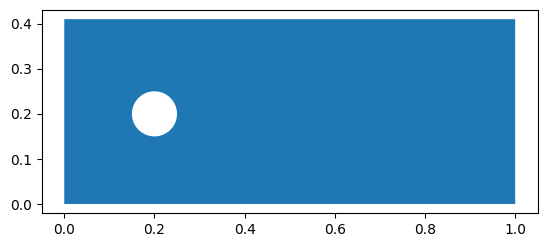

In [2]:
(xmin,xmax),(ymin,ymax) = (0,1), (0,0.41)
domain = Rectangle(((xmin,ymin),(xmax,ymax) ),'corners')
domain = Domain2D(base = domain)

hole = Circle((0.2,0.2),r = 0.05,num_points= 512)
domain.remove(hole,names= ['Cylinder'])

a = gpd.GeoSeries(domain.Domain)
a.plot()

In [3]:
sdf = domain.create_sdf(resolution = 100)
X,Y = torch.meshgrid(torch.linspace(xmin,xmax,200),torch.linspace(ymin,ymax,200))
x,y = X.flatten(),Y.flatten()
a = torch.stack((x,y),dim = -1).cuda()
sdf.set_device('cuda')
z = sdf(a)

c:\Users\John Su\Downloads\Py_DE\env\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\John Su\Downloads\Py_DE\Pytorch_PINNs\src\torch_DE\continuous\utils\GridInterpolator.py:62: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:/actions-runner/_work/pytorch/pytorch/builder/windows/pytorch/aten/src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


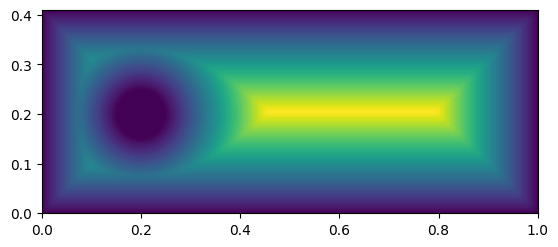

In [4]:
plt.gca().set_aspect('equal')
plt.tricontourf(x.cpu(),y.cpu(),z.cpu(),levels = 100)


In [5]:
sampled_points = domain.generate_points(400_000)

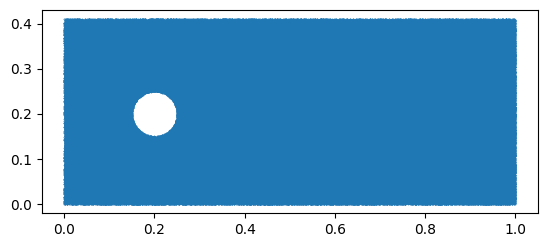

In [6]:
plt.gca().set_aspect('equal')
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=0.1)


In [6]:
domain.add_boundary_group('Cylinder','Cyl_No_Slip')
b_groups =domain.boundary_groups 
cyl = b_groups['Cyl_No_Slip']
cyl_points = torch.tensor(list(cyl.coords))
inlet = domain.generate_points_from_line(b_groups['exterior_edge_0'],100,random = False)
outlet = domain.generate_points_from_line(b_groups['exterior_edge_2'],100,random = False)
top = domain.generate_points_from_line(b_groups['exterior_edge_1'],100,random = False)
bot = domain.generate_points_from_line(b_groups['exterior_edge_3'],100,random = False)

In [7]:
import inspect
def Stokes_Flow(u_x,u_xx,u_yy,p_x,v_y,v_xx,v_yy,p_y,Re = 20, **kwargs):
    NS_y =p_y - 1/Re*(v_xx + v_yy)
    return NS_y

def Stokes_Flow_x(u_xx,u_yy,p_x,Re = 20, **kwargs):
    NS_x =p_x - 1/Re*(u_xx + u_yy)
    return NS_x

def Stokes_Flow_y(v_xx,v_yy,p_y,Re = 20, **kwargs):
    NS_y =p_y - 1/Re*(v_xx + v_yy)
    return NS_y

def incomp(u_x,v_y, **kwargs):
    incomp = u_x + v_y
    return incomp


derivative_names = set(inspect.signature(Stokes_Flow).parameters.keys())
for a in ['kwargs','u','v','Re']:
    if a in derivative_names:
        derivative_names.remove(a)
derivative_names


U = 0.3
u_inlet_func = lambda x : 4*U*x[:,1]*(0.41-x[:,1])/(0.41**2)


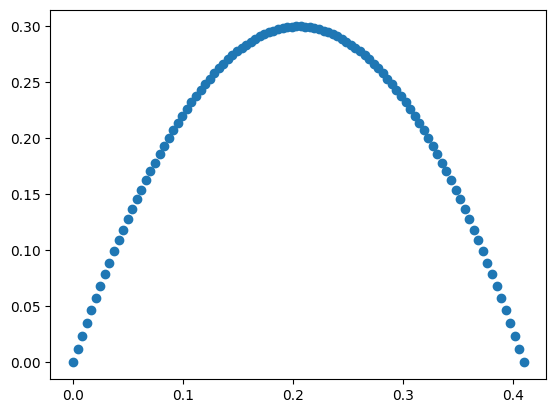

In [8]:
test = u_inlet_func(inlet)
plt.scatter(inlet[:,1],test)

In [9]:
def sample_from_tensor(num_points,t,dim = 0):
    return t[torch.randint(low =0,high = t.shape[dim],size = (num_points,))]

In [14]:
#DATA
data  = Data_handler()
data['collocation points'] = sample_from_tensor(2000,sampled_points,0)
data['inlet'] = inlet
data['outlet'] = outlet
data['no_slip_walls'] = torch.cat([top,bot],dim = 0)
data['cylinder'] = cyl_points
data.set_to_device('cuda')
#PYTORCH SETUP
torch.manual_seed(1234)


net = MLP(2,3,128,6,activation='sin')
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,10000,0.9)

#SET UP DERIVATIVES
PINN = DE_Getter(net)
PINN.set_vars(['x','y'],['u','v','p'])
PINN.set_derivatives(derivative_names)
FD = FD_engine(net = net,derivatives= PINN.derivatives,dxs = [0.01,0.01],sdf= sdf)
PINN.set_deriv_method(FD)
net = net.cuda()

#LOSSES
losses = Loss_handler(data.group_names())
losses.add_boundary('inlet',{'u':u_inlet_func,
                             'v':0})

losses.add_boundary('outlet',{'u':u_inlet_func,
                             'v':0})


losses.add_boundary('cylinder',{'u':0,
                                'v':0 })

losses.add_boundary('no_slip_walls',{'u':0,
                                     'v':0 })

losses.add_residual('collocation points',{'stokes_x':Stokes_Flow_x,
                                          'stokes_y':Stokes_Flow_y, 
                                          'incomp':incomp },weighting=sdf)
#SAMPLING STRATEGY
sampler = R3_sampler(sample_from_tensor)


#Post Processing
def in_cyl(x,y,centre,radius):
    x1,y1 = centre
    return (x-x1).pow(2) + (y-y1).pow(2) >= radius**2


xy = torch.meshgrid(torch.linspace(xmin,xmax,100),torch.linspace(ymin,ymax,100))
x = xy[0].flatten()
y = xy[1].flatten()

in_cyl_mask = in_cyl(x,y,(0.2,0.2),radius=0.05)

x = x[in_cyl_mask]
y= y[in_cyl_mask]
tri_ang = tri.Triangulation(x, y)


Set all tensors to device cuda


In [ ]:
for i in range(100_000):
    data.set_to_device('cuda',to_show= False)
    output = PINN.calculate(data,target_group = 'collocation points')
    res = sum([losses.loss_groups['Residual']['collocation points'][i](data,output) for i in ['stokes_x','stokes_y','incomp']]) 

    ls = losses.calculate(data,output)
    BC_loss,res_loss = ls['Boundary'],ls['Residual']
    loss =  res_loss +BC_loss

    optimizer.zero_grad()
    # print(f'Epoch {i} Total Loss {float(loss):.2E} Res Loss {float(res_loss):.2E} BC Loss {float(BC_loss):.2E}' )
    losses.print_losses(i)
    loss.backward()
    optimizer.step()
    LR_sch.step()
    data['collocation points'] = sampler(data['collocation points'],res,t=sampled_points)
    if (i % 500) == 0:
        losses.log_loss()
    if (i % 10_000 == 0):        
        net = net.cpu()
        with torch.no_grad():
            u = net(torch.stack([x,y],-1))
            u.device
            plt.figure(figsize=(16,4))
            plt.gca().set_aspect('equal')
            plt.tricontourf(tri_ang,u[:,0],levels = 100,cmap = 'jet' )
            plt.gca().add_patch(pltCircle((0.2,0.2),radius= 0.05,color = 'white'))
            plt.colorbar(orientation = 'horizontal')
            plt.title(f'u vel at epoch {i}')
            plt.savefig(f'FD_SDF_On/u_vel_epoch_{i}.jpg')

        net = net.cuda()